In [1]:
__author__ = 'Monika Soraisam'
__email__ = 'monika.soraisam@noirlab.edu'

In [2]:
## if trouble with conda env https://stackoverflow.com/questions/70958434/unexpected-python-paths-in-conda-environment

### Set up DRAGONS

In [3]:
import os
from pathlib import Path
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [4]:
# Now import the DRAGONS libraries 
import astrodata
import gemini_instruments
from recipe_system import cal_service
from gempy.adlibrary import dataselect
from gempy.utils import logutils

from recipe_system.reduction.coreReduce import Reduce
from gempy.scripts import showpars
from gempy.utils.showrecipes import showrecipes
from gempy.utils.showrecipes import showprims

Ginga not installed, use other viewer, or no viewer


In [5]:
## prep the reduction folder
def prep_reduction_folder(data_root, obsid):
    reduction_path = Path(f"{data_root}/{obsid}/reduction")

    if not reduction_path.exists():
        os.mkdir(reduction_path.as_posix())
        print (f"directory for dragons reduction created")
    
    ## change the cwd to the reduction folder
    os.chdir(reduction_path.as_posix())
    print(f"Current working directory is: {os.getcwd()}")

    ## write the configuration file 
    mydb = "dragons_for_goats.db" 
    mydb_path = reduction_path.as_posix() + '/' + mydb
    print (mydb_path)
    
    dragons_rc = reduction_path.as_posix() + '/dragonsrc'
    print (dragons_rc)
    
    with open(dragons_rc, "w") as f:
        f.write("[calibs]\ndatabases = {0} get store".format(mydb_path))

    return dragons_rc, mydb_path


### GMOS imaging example -- GN-2015A-Q-86-5

In [6]:
data_path = "/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM"
obsid = 'GN-2015A-Q-86-5'  # GMOS imaging example 
dragons_rc, mydb_path = prep_reduction_folder(data_path, obsid)

# ## set the environment varaible to read the configuration file
# os.environ["DRAGONSRC"] = dragons_rc
# print (f"$DRAGONSRC value is {os.environ.get('DRAGONSRC')}")

Current working directory is: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction/dragons_for_goats.db
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction/dragonsrc


In [7]:
# # Now import the DRAGONS libraries 
# import astrodata
# import gemini_instruments
# from recipe_system import cal_service
# from gempy.adlibrary import dataselect
# from gempy.utils import logutils

# from recipe_system.reduction.coreReduce import Reduce
# from gempy.scripts import showpars
# from gempy.utils.showrecipes import showrecipes
# from gempy.utils.showrecipes import showprims

In [8]:
# initialize the calibration database and complete the set-up 
caldb = cal_service.LocalDB(mydb_path, force_init=True) # 

## verify that the correct cal db is loaded
cal_service.load_config()
print (cal_service.get_db_path_from_config())

/home/msoraisam/Desktop/DRAGONS/science_verification/my_drgsv/21tdu.db


**Note above that the `cal_service` has loaded a different database than the one we have specified above `dragons_for_goats.db` for this program. This is because the `cal_service` is reading the databse name from the default dragons config file and not the one we have specificed above. However, we can input the correct config file while calling reduce as shown below.** 

### Generate filelist for the data reduction

In [8]:
def generate_filelists(location, obsid):
    """
    Parameters
    ----------
    location: str
        Root folder where the Gemini data for a given target is located
    obsid: str
        Gemini observation ID 
    """

    
    all_files = [str(pp) for pp in list(Path(location+"/"+obsid).glob('*.fits'))]
    all_files.sort()
    print (f'The total number of files for observation ID {obsid} is {len(all_files)}')

    cal_file_tags = ['BIAS','DARK','FLAT','ARC','PINHOLE','RONCHI','FRINGE'] #fetched from Obs Type search field on GOA, which is relevant for DRAGONS

    meta_keys = cal_file_tags + ['BPM','standard','object', 'unknown']
    all_meta = {}

    for K in meta_keys:
        all_meta[K] = {'file':[],
                        'group_id':[],
                        'exp':[],
                        'objname':[],
                        'wave':[],
                        'waveband':[],
                        'date':[],
                        'roi':[],
                        }

    object_files = []
    for i,F in enumerate(all_files):
        ad = astrodata.open(F)

        K = "unknown"
        if "BPM" in ad.tags:
            K = "BPM"
        elif "PREPARED" in ad.tags:
            continue
        elif ("STANDARD" in ad.tags or ad.observation_class()=="partnerCal" or ad.observation_class()=="progCal") and ("UNPREPARED" in ad.tags) and (ad.observation_type()=="OBJECT"):
            K = "standard"            
        elif "CAL" in ad.tags and "UNPREPARED" in ad.tags:
            for tag in cal_file_tags:
                if tag in ad.tags:
                    K = tag
        elif ad.observation_class()=="science" and "UNPREPARED" in ad.tags:
            K = "object"
            
        all_meta[K]['file'].append(F)
        # group_id seems to be not implemented for GNIRS yet
        if "GNIRS" in ad.instrument():
            all_meta[K]['group_id'].append(None)
        else:
            all_meta[K]['group_id'].append(ad.group_id())
        all_meta[K]['exp'].append(ad.exposure_time())
        all_meta[K]['objname'].append(ad.object())
        all_meta[K]['wave'].append(ad.central_wavelength())
        all_meta[K]['waveband'].append(ad.wavelength_band())
        all_meta[K]['date'].append(ad.ut_date())
        all_meta[K]['roi'].append(ad.detector_roi_setting()) 
        #print (F.split('/')[-1], ad.object(), ad.tags)
    
    return all_meta


In [9]:
all_meta = generate_filelists(data_path, obsid)

for K,V in all_meta.items():
    if len(V['file'])==0:
        continue
    print (f"There are {len(V['file'])} files for observation type {K}") 

The total number of files for observation ID GN-2015A-Q-86-5 is 694
There are 325 files for observation type BIAS
There are 80 files for observation type FLAT
There are 1 files for observation type BPM
There are 4 files for observation type standard
There are 276 files for observation type object


In [12]:
DF_bias = pd.DataFrame(all_meta['BIAS'])
DF_flat = pd.DataFrame(all_meta['FLAT'])
DF_bpm = pd.DataFrame(all_meta['BPM'])
DF_object = pd.DataFrame(all_meta['object'])
DF_standard = pd.DataFrame(all_meta['standard'])


In [13]:
print (f"There are {len(np.unique(DF_object['objname'].values))} science targets in this observation set, namely {np.unique(DF_object['objname'].values)}")

There are 1 science targets in this observation set, namely ['J1655+2533']


In [22]:
## add BPM to the calibration database (the BPM is already processed)
for F in caldb.list_files():
    print (F)

for F in DF_bpm['file'].values:
    caldb.add_cal(F)

for F in caldb.list_files():
    print (F)

FileData(name='bpm_20111025_gmos-n_e2v_44_full_6amp.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5')


### Based on the **observation type** we see above for this data set, we can come up with the full reduction plan. E.g., 
process bias -> process flat -> (process fringe->) process standard -> process science

Note that for **some GMOS imaging** data, the step in bracket above needs to be done (see https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.1.0/04_tips_and_tricks.html#tips-and-tricks). The detector and filter combination will indicate which data sets will require fringe frame (https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.1.0/appendices/02_fringe_correction_tables.html#fringe-correction-tables).  

In [14]:
logutils.config(file_name='gmos_data_reduction.log') # logger

In [46]:
def dragons_reduce(filelist, alt_recipe=None, uparams=None):
    """
    Parameters
    ----------
    filelist: list 
        list of files of a given observation type
    alt_recipe: str
        alternative recipe name, if not using the default recipe
    uparams: list of tuples
        user supplied parameters for primitives in the recipe 
    """
    reduce = Reduce()
    reduce.files.extend(filelist)
    if alt_recipe is not None:
        reduce.recipename = alt_recipe
    if uparams is not None:
        reduce.uparms = uparams 
    print (f"Showing primitives of the recipe to be used:\n {showprims(filelist[0])}")
    reduce.runr()

In [110]:
## GOA associates a bunch of bias frames (going 6 months back or something) more than necessary, which at times impact the quality of reduced science data product
## Will process bias from 10 days at a time, which should help

DF_all_objects = pd.concat([DF_standard, DF_object], ignore_index=True) 

for K, V in DF_bias.groupby('group_id'):
    if len(V) > 20:
        min_date = min(DF_all_objects['date'].values) - datetime.timedelta(days=5.0)
        max_date = min_date + datetime.timedelta(days=10.0) 
        while max_date < (max(DF_all_objects['date'].values) + datetime.timedelta(days=1.0)): ## can consider having users provide a date range if they want
            mask = (V['date'] > min_date) & (V['date'] < max_date)
            print (f"Number of bias frames this run is {np.sum(mask)} for dates between {min_date} and {max_date}")
            min_date = max_date 
            max_date = min_date + datetime.timedelta(days=10.0)            
            if np.sum(mask)==0:
                continue
            dragons_reduce(list(V['file'].values[mask]))

                                          All submitted files appear valid:
                                          /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150413S0302.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150421S0640.fits, 40 files submitted.


Number of bias frames this run is 40 for dates between 2015-04-12 and 2015-04-22
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedBias) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150413S0302.fits
Input tags: ['CAL', 'GMOS', 'RAW', 'AZEL_TARGET', 'AT_ZENITH', 'UNPREPARED', 'BIAS', 'NON_SIDEREAL', 'GEMINI', 'NORTH']
Input mode: sq
Input recipe: makeProcessedBias
Matched recipe: geminidr.gmos.recipes.sq.recipes_BIAS::makeProcessedBias
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_BIAS.py
Recipe tags: {'BIAS', 'CAL', 'GMOS'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.overscanCorrect()
   p.stackBiases()
   p.makeIRAFCompatible()
   p.storeProcessedBias()


                                          RECIPE: makeProcessedBias
                                             PRIMITIVE: prepare
                                             ------------------
                                                PRIMITIVE: validateData
                                                -----------------------
                                                .
                                                PRIMITIVE: standardizeStructure
                                                -------------------------------
                                                .
                                                PRIMITIVE: standardizeHeaders
                                                -----------------------------
                                                   PRIMITIVE: standardizeObservatoryHeaders
                                                   ----------------------------------------
                                                   Updating 

Number of bias frames this run is 5 for dates between 2015-04-22 and 2015-05-02
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedBias) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150424S0377.fits
Input tags: ['CAL', 'GMOS', 'RAW', 'AZEL_TARGET', 'AT_ZENITH', 'UNPREPARED', 'BIAS', 'NON_SIDEREAL', 'GEMINI', 'NORTH']
Input mode: sq
Input recipe: makeProcessedBias
Matched recipe: geminidr.gmos.recipes.sq.recipes_BIAS::makeProcessedBias
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_BIAS.py
Recipe tags: {'BIAS', 'CAL', 'GMOS'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.overscanCorrect()
   p.stackBiases()
   p.makeIRAFCompatible()
   p.storeProcessedBias()


                                          RECIPE: makeProcessedBias
                                             PRIMITIVE: prepare
                                             ------------------
                                                PRIMITIVE: validateData
                                                -----------------------
                                                .
                                                PRIMITIVE: standardizeStructure
                                                -------------------------------
                                                .
                                                PRIMITIVE: standardizeHeaders
                                                -----------------------------
                                                   PRIMITIVE: standardizeObservatoryHeaders
                                                   ----------------------------------------
                                                   Updating 

Number of bias frames this run is 0 for dates between 2015-05-02 and 2015-05-12
Number of bias frames this run is 0 for dates between 2015-05-12 and 2015-05-22
Number of bias frames this run is 0 for dates between 2015-05-22 and 2015-06-01
Number of bias frames this run is 0 for dates between 2015-06-01 and 2015-06-11
Number of bias frames this run is 40 for dates between 2015-04-12 and 2015-04-22
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedBias) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150413S0352.fits
Input tags: ['CAL', 'GMOS', 'RAW', 'AZEL_TARGET', 'AT_ZENITH', 'UNPREPARED', 'BIAS', 'NON_SIDEREAL', 'GEMINI', 'NORTH']
Input mode: sq
Input recipe: makeProcessedBias
Matched recipe: geminidr.gmos.recipes.sq.recipes_BIAS::makeProcessedBias
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_

                                          RECIPE: makeProcessedBias
                                             PRIMITIVE: prepare
                                             ------------------
                                                PRIMITIVE: validateData
                                                -----------------------
                                                .
                                                PRIMITIVE: standardizeStructure
                                                -------------------------------
                                                .
                                                PRIMITIVE: standardizeHeaders
                                                -----------------------------
                                                   PRIMITIVE: standardizeObservatoryHeaders
                                                   ----------------------------------------
                                                   Updating 

Number of bias frames this run is 35 for dates between 2015-04-22 and 2015-05-02
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedBias) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150424S0427.fits
Input tags: ['CAL', 'GMOS', 'RAW', 'AZEL_TARGET', 'AT_ZENITH', 'UNPREPARED', 'BIAS', 'NON_SIDEREAL', 'GEMINI', 'NORTH']
Input mode: sq
Input recipe: makeProcessedBias
Matched recipe: geminidr.gmos.recipes.sq.recipes_BIAS::makeProcessedBias
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_BIAS.py
Recipe tags: {'BIAS', 'CAL', 'GMOS'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.overscanCorrect()
   p.stackBiases()
   p.makeIRAFCompatible()
   p.storeProcessedBias()


                                          RECIPE: makeProcessedBias
                                             PRIMITIVE: prepare
                                             ------------------
                                                PRIMITIVE: validateData
                                                -----------------------
                                                .
                                                PRIMITIVE: standardizeStructure
                                                -------------------------------
                                                .
                                                PRIMITIVE: standardizeHeaders
                                                -----------------------------
                                                   PRIMITIVE: standardizeObservatoryHeaders
                                                   ----------------------------------------
                                                   Updating 

Number of bias frames this run is 15 for dates between 2015-05-02 and 2015-05-12
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedBias) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150503S0381.fits
Input tags: ['CAL', 'GMOS', 'RAW', 'AZEL_TARGET', 'AT_ZENITH', 'UNPREPARED', 'BIAS', 'NON_SIDEREAL', 'GEMINI', 'NORTH']
Input mode: sq
Input recipe: makeProcessedBias
Matched recipe: geminidr.gmos.recipes.sq.recipes_BIAS::makeProcessedBias
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_BIAS.py
Recipe tags: {'BIAS', 'CAL', 'GMOS'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.overscanCorrect()
   p.stackBiases()
   p.makeIRAFCompatible()
   p.storeProcessedBias()


                                          RECIPE: makeProcessedBias
                                             PRIMITIVE: prepare
                                             ------------------
                                                PRIMITIVE: validateData
                                                -----------------------
                                                .
                                                PRIMITIVE: standardizeStructure
                                                -------------------------------
                                                .
                                                PRIMITIVE: standardizeHeaders
                                                -----------------------------
                                                   PRIMITIVE: standardizeObservatoryHeaders
                                                   ----------------------------------------
                                                   Updating 

Number of bias frames this run is 0 for dates between 2015-05-12 and 2015-05-22
Number of bias frames this run is 10 for dates between 2015-05-22 and 2015-06-01
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedBias) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150531S0435.fits
Input tags: ['CAL', 'GMOS', 'RAW', 'AZEL_TARGET', 'AT_ZENITH', 'UNPREPARED', 'BIAS', 'NON_SIDEREAL', 'GEMINI', 'NORTH']
Input mode: sq
Input recipe: makeProcessedBias
Matched recipe: geminidr.gmos.recipes.sq.recipes_BIAS::makeProcessedBias
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_BIAS.py
Recipe tags: {'BIAS', 'CAL', 'GMOS'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.overscanCorrect()
   p.stackBiases()
   p.makeIRAFCompatible()
   p.storeProcessedBias()


                                          RECIPE: makeProcessedBias
                                             PRIMITIVE: prepare
                                             ------------------
                                                PRIMITIVE: validateData
                                                -----------------------
                                                .
                                                PRIMITIVE: standardizeStructure
                                                -------------------------------
                                                .
                                                PRIMITIVE: standardizeHeaders
                                                -----------------------------
                                                   PRIMITIVE: standardizeObservatoryHeaders
                                                   ----------------------------------------
                                                   Updating 

Number of bias frames this run is 35 for dates between 2015-06-01 and 2015-06-11
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedBias) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150603S0361.fits
Input tags: ['CAL', 'GMOS', 'RAW', 'AZEL_TARGET', 'AT_ZENITH', 'UNPREPARED', 'BIAS', 'NON_SIDEREAL', 'GEMINI', 'NORTH']
Input mode: sq
Input recipe: makeProcessedBias
Matched recipe: geminidr.gmos.recipes.sq.recipes_BIAS::makeProcessedBias
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_BIAS.py
Recipe tags: {'BIAS', 'CAL', 'GMOS'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.overscanCorrect()
   p.stackBiases()
   p.makeIRAFCompatible()
   p.storeProcessedBias()


                                          RECIPE: makeProcessedBias
                                             PRIMITIVE: prepare
                                             ------------------
                                                PRIMITIVE: validateData
                                                -----------------------
                                                .
                                                PRIMITIVE: standardizeStructure
                                                -------------------------------
                                                .
                                                PRIMITIVE: standardizeHeaders
                                                -----------------------------
                                                   PRIMITIVE: standardizeObservatoryHeaders
                                                   ----------------------------------------
                                                   Updating 

In [111]:
# Let's see how many files are now registered in the calibration database
for F in caldb.list_files():
    print (F)

FileData(name='N20150413S0302_bias.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction/calibrations/processed_bias')
FileData(name='N20150413S0352_bias.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction/calibrations/processed_bias')
FileData(name='N20150424S0377_bias.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction/calibrations/processed_bias')
FileData(name='N20150424S0427_bias.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction/calibrations/processed_bias')
FileData(name='N20150503S0381_bias.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction/calibrations/processed_bias')
FileData(name='N20150531S0435_bias.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data

All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150412S0176.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150419S0223.fits, 20 files submitted.


g_2_2_Normal_["'e2v 10031-23-05, right':[1025:2048,1:4608]", "'e2v 10031-23-05, left':[1:1024,1:4608]", "'e2v 10031-01-03, right':[3073:4096,1:4608]", "'e2v 10031-01-03, left':[2049:3072,1:4608]", "'e2v 10031-18-04, left':[4097:5120,1:4608]", "'e2v 10031-18-04, right':[5121:6144,1:4608]"] 20 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedFlat) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150412S0176.fits
Input tags: ['RAW', 'IMAGE', 'GEMINI', 'NORTH', 'SIDEREAL', 'CAL', 'GMOS', 'FLAT', 'TWILIGHT', 'UNPREPARED']
Input mode: sq
Input recipe: makeProcessedFlat
Matched recipe: geminidr.gmos.recipes.sq.recipes_FLAT_IMAGE::makeProcessedFlat
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_FLAT_IMAGE.py
Recipe tags: {'IMAGE', 'CAL', 'FLAT', 'GMOS'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
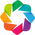

RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to al

g_4_4_Normal_["'e2v 10031-23-05, right':[1025:2048,1:4608]", "'e2v 10031-23-05, left':[1:1024,1:4608]", "'e2v 10031-01-03, right':[3073:4096,1:4608]", "'e2v 10031-01-03, left':[2049:3072,1:4608]", "'e2v 10031-18-04, left':[4097:5120,1:4608]", "'e2v 10031-18-04, right':[5121:6144,1:4608]"] 60 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedFlat) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150409S0393.fits
Input tags: ['RAW', 'IMAGE', 'GEMINI', 'NORTH', 'SIDEREAL', 'CAL', 'GMOS', 'FLAT', 'TWILIGHT', 'UNPREPARED']
Input mode: sq
Input recipe: makeProcessedFlat
Matched recipe: geminidr.gmos.recipes.sq.recipes_FLAT_IMAGE::makeProcessedFlat
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_FLAT_IMAGE.py
Recipe tags: {'IMAGE', 'CAL', 'FLAT', 'GMOS'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.

RECIPE: makeProcessedFlat
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to al

GN-CAL20150417-18_g_2_2_Normal_["'e2v 10031-23-05, right':[1025:2048,1:4608]", "'e2v 10031-23-05, left':[1:1024,1:4608]", "'e2v 10031-01-03, right':[3073:4096,1:4608]", "'e2v 10031-01-03, left':[2049:3072,1:4608]", "'e2v 10031-18-04, left':[4097:5120,1:4608]", "'e2v 10031-18-04, right':[5121:6144,1:4608]"] 4 


Check if you need to make master fringe frame (https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.1.0/appendices/02_fringe_correction_tables.html#fringe-correction-tables)
e2v 10031-23-05,10031-01-03,10031-18-04 g
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150417S0203.fits
Input tags: ['RAW', 'IMAGE', 'GEMINI', 'SIDEREAL', 'UNPREPARED', 'NORTH', 'GMOS']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.gmos.recipes.sq.recipes_IMAGE::reduce
Recipe location: /home/msoraisam/mambaforge/envs/g

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         .
      .
      PRIMITIVE: standardizeW

GN-2015A-Q-86-5_g_4_4_Normal_["'e2v 10031-23-05, right':[1025:2048,1:4608]", "'e2v 10031-23-05, left':[1:1024,1:4608]", "'e2v 10031-01-03, right':[3073:4096,1:4608]", "'e2v 10031-01-03, left':[2049:3072,1:4608]", "'e2v 10031-18-04, left':[4097:5120,1:4608]", "'e2v 10031-18-04, right':[5121:6144,1:4608]"] 276 


Check if you need to make master fringe frame (https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.1.0/appendices/02_fringe_correction_tables.html#fringe-correction-tables)
e2v 10031-23-05,10031-01-03,10031-18-04 g
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150417S0223.fits
Input tags: ['RAW', 'IMAGE', 'GEMINI', 'SIDEREAL', 'UNPREPARED', 'NORTH', 'GMOS']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.gmos.recipes.sq.recipes_IMAGE::reduce
Recipe location: /home/msoraisam/mambaforge/envs/g

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini da

In [16]:
for DF in [DF_flat, DF_standard, DF_object]:
    for K, V in DF.groupby('group_id'):
        ad = astrodata.open(V['file'].values[0])
        print (K, len(V), "\n")        
        if (ad.observation_type() == "OBJECT") and ("IMAGE" in ad.tags) and ("CAL" not in ad.tags):
            print ("\nCheck if you need to make master fringe frame (https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.1.0/appendices/02_fringe_correction_tables.html#fringe-correction-tables)")
            print (ad.detector_name(), ad.wavelength_band())
            ## if user decides to create a fringe frame, then pass 
            #alt_recipe = "makeProcessedFringe"
        dragons_reduce(list(V['file'].values))

#### When one is reducing many exposures, for example, the case above with 276 files, then memory might be limited, so the intermediates files are qritten to disk. To get around this, user can increase the memory for the relevant primitive -- for the GMOS imaging routine, it's stackFrames (see below)

In [42]:
print (f"Showing primitives of the default recipe:\n {showprims(DF_object['file'].values[0])}")

Showing primitives of the default recipe:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150417S0223.fits
Input tags: ['RAW', 'IMAGE', 'GEMINI', 'SIDEREAL', 'UNPREPARED', 'NORTH', 'GMOS']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.gmos.recipes.sq.recipes_IMAGE::reduce
Recipe location: /home/msoraisam/mambaforge/envs/goatsdev/lib/python3.11/site-packages/geminidr/gmos/recipes/sq/recipes_IMAGE.py
Recipe tags: {'GMOS', 'IMAGE'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.addVAR(read_noise=True)
   p.overscanCorrect()
   p.biasCorrect()
   p.ADUToElectrons()
   p.addVAR(poisson_noise=True)
   p.flatCorrect()
   p.fringeCorrect()
   p.QECorrect()
   p.mosaicDetectors()
   p.detectSources()
   p.adjustWCSToReference()
   p.resampleToCommonFrame()
   p.flagCosmicRaysByStacking()
   p.scaleCountsToReference()
   p.stackFrames(zero=True)
   p.storeProce

In [43]:
pobj, tags = showpars.get_pars(DF_object['file'].values[0]) # returns the primitive class object and astrodata tags
showpars.showpars(pobj, 'stackFrames', tags, show_docstring=None)

Dataset tagged as {'RAW', 'GEMINI', 'IMAGE', 'NORTH', 'SIDEREAL', 'GMOS', 'UNPREPARED'}

Settable parameters on 'stackFrames':
Name                 Current setting      Description

suffix               '_stack'             Filename suffix
apply_dq             True                 Use DQ to mask bad pixels?
statsec              None                 Section for statistics
operation            'mean'               Averaging operation
Allowed values:
	mean	arithmetic mean
	wtmean	variance-weighted mean
	median	median
	lmedian	low-median

reject_method        'sigclip'            Pixel rejection method
Allowed values:
	none	no rejection
	minmax	reject highest and lowest pixels
	sigclip	reject pixels based on scatter
	varclip	reject pixels based on variance array

hsigma               3.0                  High rejection threshold (sigma)
	Valid Range = [0,inf)
lsigma               3.0                  Low rejection threshold (sigma)
	Valid Range = [0,inf)
mclip                True          

In [48]:
## reducing again DF_object after increasing the memory. We will set it to None to use all available
for K, V in DF_object.groupby('group_id'):
    ad = astrodata.open(V['file'].values[0])
    print (K, len(V), "\n")        
    if (ad.observation_type() == "OBJECT") and ("IMAGE" in ad.tags) and ("CAL" not in ad.tags):
        print ("\nCheck if you need to make master fringe frame (https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.1.0/appendices/02_fringe_correction_tables.html#fringe-correction-tables)")
        print (ad.detector_name(), ad.wavelength_band())
        ## if user decides to create a fringe frame, then pass 
        #alt_recipe = "makeProcessedFringe"
    dragons_reduce(list(V['file'].values), uparams=[('stackFrames:memory', None)]) # is uparams=[('memory', None)], then this memory value will be applied to all primitives containing a memory parameter

All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150417S0223.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150618S0174.fits, 276 files submitted.


GN-2015A-Q-86-5_g_4_4_Normal_["'e2v 10031-23-05, right':[1025:2048,1:4608]", "'e2v 10031-23-05, left':[1:1024,1:4608]", "'e2v 10031-01-03, right':[3073:4096,1:4608]", "'e2v 10031-01-03, left':[2049:3072,1:4608]", "'e2v 10031-18-04, left':[4097:5120,1:4608]", "'e2v 10031-18-04, right':[5121:6144,1:4608]"] 276 


Check if you need to make master fringe frame (https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.1.0/appendices/02_fringe_correction_tables.html#fringe-correction-tables)
e2v 10031-23-05,10031-01-03,10031-18-04 g
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/N20150417S0223.fits
Input tags: ['RAW', 'IMAGE', 'GEMINI', 'SIDEREAL', 'UNPREPARED', 'NORTH', 'GMOS']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.gmos.recipes.sq.recipes_IMAGE::reduce
Recipe location: /home/msoraisam/mambaforge/envs/g

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini da

#### See what data products are finally present in the reduction folder 

In [49]:
!ls /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction

calibrations		  N20150412S0176_flat.fits   N20150424S0377_bias.fits
dragons_for_goats.db	  N20150413S0302_bias.fits   N20150424S0427_bias.fits
dragonsrc		  N20150413S0352_bias.fits   N20150503S0381_bias.fits
gmos_data_reduction.log   N20150417S0203_image.fits  N20150531S0435_bias.fits
N20150409S0393_flat.fits  N20150417S0223_image.fits  N20150603S0361_bias.fits


Filename: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2015A-Q-86-5/reduction/N20150417S0223_image.fits
Tags: GEMINI GMOS IMAGE NORTH OVERSCAN_SUBTRACTED OVERSCAN_TRIMMED PREPARED
    PROCESSED PROCESSED_SCIENCE SIDEREAL

Pixels Extensions
Index  Content                  Type              Dimensions     Format
[ 0]   science                  NDAstroData       (1153, 1556)   float32
          .variance             ADVarianceUncerta (1153, 1556)   float32
          .mask                 ndarray           (1153, 1556)   uint16

Other Extensions
               Type        Dimensions
.PROVENANCE    Table       (281, 4)
.PROVHISTORY   Table       (18, 4)


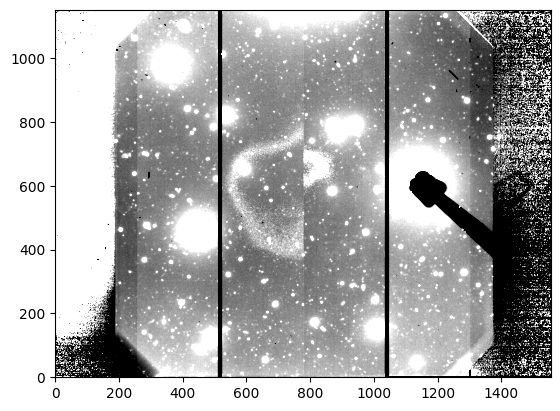

In [62]:
# plotting the reduced image

plt.close('all')
fig, ax = plt.subplots()
ad = astrodata.open(f"{reduction_path}/N20150417S0223_image.fits")
ad.info()
ax.imshow(ad[0].data, origin="lower", cmap='grey', vmin=np.percentile(ad[0].data, 10), vmax=np.percentile(ad[0].data, 80))
plt.show()

## Another way to run the recipe, which will allow modifying the parameters conveniently 

In [25]:
import geminidr.gmos as gmos

In [26]:
dir(gmos)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lookups',
 'parameters_gmos',
 'parameters_gmos_ifu',
 'parameters_gmos_image',
 'parameters_gmos_longslit',
 'parameters_gmos_mos',
 'parameters_gmos_nodandshuffle',
 'parameters_gmos_spect',
 'primitives_gmos',
 'primitives_gmos_ifu',
 'primitives_gmos_image',
 'primitives_gmos_longslit',
 'primitives_gmos_mos',
 'primitives_gmos_nodandshuffle',
 'primitives_gmos_spect',
 'recipes']

In [28]:
dir(gmos.primitives_gmos_image)

['DQ',
 'GMOS',
 'GMOSImage',
 'Image',
 'NDStacker',
 'Photometry',
 'UnivariateSpline',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_modify_fringe_params',
 'capture_provenance',
 'cf',
 'control_pairs',
 'deepcopy',
 'detsec_to_pixels',
 'gWCS',
 'geometry_conf',
 'gt',
 'models',
 'ndimage',
 'np',
 'optimize',
 'parameter_override',
 'parameters_gmos_image',
 'transform']

In [29]:
def myrecipe(p): 
    
    """
    Parameters
    ----------
    p : :class:`geminidr.gmos.primitives_gmos_image.GMOSImage`
    """
    p.prepare()
    p.addDQ()
    p.addVAR(read_noise=True)
    p.overscanCorrect()
    p.biasCorrect()
    p.ADUToElectrons()
    p.addVAR(poisson_noise=True)
    p.flatCorrect()
    p.fringeCorrect()
    p.QECorrect()
    p.mosaicDetectors()
    p.detectSources()
    p.adjustWCSToReference()
    p.resampleToCommonFrame()
    p.flagCosmicRaysByStacking()
    p.scaleCountsToReference()
    p.stackFrames(zero=True)
    p.storeProcessedScience(suffix="_image")


In [35]:
for K, V in DF_standard.groupby("group_id"):
    print (K)
    adin = []
    for f in V['file'].values:
        adin.append(astrodata.open(f))
    print (f"Reducing {len(adin)} files")
    p = gmos.primitives_gmos_image.GMOSImage(adin)
    myrecipe(p)

GN-CAL20150417-18_g_2_2_Normal_["'e2v 10031-23-05, right':[1025:2048,1:4608]", "'e2v 10031-23-05, left':[1:1024,1:4608]", "'e2v 10031-01-03, right':[3073:4096,1:4608]", "'e2v 10031-01-03, left':[2049:3072,1:4608]", "'e2v 10031-18-04, left':[4097:5120,1:4608]", "'e2v 10031-18-04, right':[5121:6144,1:4608]"]
Reducing 4 files


   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         .
      .
      PRIMITIVE: standardizeWCS
      ------

#
# Moving on to the GMOS spectroscopic reduction (classic) -- GN-2018B-Q-315-11
(Restart the jupyter kernel and start execution from here)

In [1]:
import os
from pathlib import Path
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime

# for bokeh apps to load from the jupyter notebook on a different browser
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Now import the DRAGONS libraries 
import astrodata
import gemini_instruments
from recipe_system import cal_service
from gempy.adlibrary import dataselect
from gempy.utils import logutils

from recipe_system.reduction.coreReduce import Reduce
from gempy.scripts import showpars
from gempy.utils.showrecipes import showrecipes
from gempy.utils.showrecipes import showprims

Ginga not installed, use other viewer, or no viewer


In [3]:
## prep the reduction folder
def prep_reduction_folder(data_root, obsid):
    reduction_path = Path(f"{data_root}/{obsid}/reduction")

    if not reduction_path.exists():
        os.mkdir(reduction_path.as_posix())
        print (f"directory for dragons reduction created")
    
    ## change the cwd to the reduction folder
    os.chdir(reduction_path.as_posix())
    print(f"Current working directory is: {os.getcwd()}")

    ## write the configuration file 
    #mydb = "dragons_for_goats.db" 
    mydb = "dragons_for_goats2.db"     
    mydb_path = reduction_path.as_posix() + '/' + mydb
    print (mydb_path)
    
    dragons_rc = reduction_path.as_posix() + '/dragonsrc'
    print (dragons_rc)
    
    with open(dragons_rc, "w") as f:
        f.write("[calibs]\ndatabases = {0} get store".format(mydb_path))

    return dragons_rc, mydb_path


In [4]:
data_path = "/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM"
obsid = 'GN-2018B-Q-315-11'
dragons_rc, mydb_path = prep_reduction_folder(data_path, obsid)

# ## set the environment varaible to read the configuration file
# os.environ["DRAGONSRC"] = dragons_rc
# print (f"$DRAGONSRC value is {os.environ.get('DRAGONSRC')}")

Current working directory is: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/dragons_for_goats2.db
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/dragonsrc


In [5]:
# # Now import the DRAGONS libraries 
# import astrodata
# import gemini_instruments
# from recipe_system import cal_service
# from gempy.adlibrary import dataselect
# from gempy.utils import logutils

# from recipe_system.reduction.coreReduce import Reduce
# from gempy.scripts import showpars
# from gempy.utils.showrecipes import showrecipes
# from gempy.utils.showrecipes import showprims

In [6]:
print(f"Confirming current working directory is: {os.getcwd()}")

Confirming current working directory is: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction


In [7]:
# initialize the calibration database and complete the set-up 
caldb = cal_service.LocalDB(mydb_path, force_init=True) # 

## verify that the correct cal db is loaded
cal_service.load_config()
print (cal_service.get_db_path_from_config())

2024-03-19 17:04:09 STDINFO  - Local database file /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/dragons_for_goats2.db does not exist. Initializing.
Local database file /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/dragons_for_goats2.db does not exist. Initializing.


/home/msoraisam/Desktop/DRAGONS/science_verification/my_drgsv/21tdu.db


**Note above that the `cal_service` has loaded a different database than the one we have specified above `dragons_for_goats.db` for this program. This is because the `cal_service` is reading the database name from the default dragons config file and not the one we have specificed above. However, we can input the correct config file while calling reduce as shown below.**

### Generate filelist for the data reduction

In [8]:
def generate_filelists(location, obsid):
    """
    Parameters
    ----------
    location: str
        Root folder where the Gemini data for a given target is located
    obsid: str
        Gemini observation ID 
    """

    
    all_files = [str(pp) for pp in list(Path(location+"/"+obsid).glob('*.fits'))]
    all_files.sort()
    print (f'The total number of files for observation ID {obsid} is {len(all_files)}')

    cal_file_tags = ['BIAS','DARK','FLAT','ARC','PINHOLE','RONCHI','FRINGE'] #fetched from Obs Type search field on GOA, which is relevant for DRAGONS

    meta_keys = cal_file_tags + ['BPM','standard','object','unknown']
    all_meta = {}

    for K in meta_keys:
        all_meta[K] = {'file':[],
                        'group_id':[],
                        'exp':[],
                        'objname':[],
                        'wave':[],
                        'waveband':[],
                        'date':[],
                        'roi':[],
                        }

    object_files = []
    for i,F in enumerate(all_files):
        ad = astrodata.open(F)

        K = "unknown"
        if "BPM" in ad.tags:
            K = "BPM"
        elif "PREPARED" in ad.tags:
            continue
        elif ("STANDARD" in ad.tags or ad.observation_class()=="partnerCal" or ad.observation_class()=="progCal") and ("UNPREPARED" in ad.tags) and (ad.observation_type()=="OBJECT"):
            K = "standard"            
        elif "CAL" in ad.tags and "UNPREPARED" in ad.tags:
            for tag in cal_file_tags:
                if tag in ad.tags:
                    K = tag
        elif ad.observation_class()=="science" and "UNPREPARED" in ad.tags:
            K = "object"
            
        all_meta[K]['file'].append(F)
        # group_id seems to be not implemented for GNIRS yet
        if "GNIRS" in ad.instrument():
            all_meta[K]['group_id'].append(None)
        else:
            all_meta[K]['group_id'].append(ad.group_id())
        all_meta[K]['exp'].append(ad.exposure_time())
        all_meta[K]['objname'].append(ad.object())
        all_meta[K]['wave'].append(ad.central_wavelength())
        all_meta[K]['waveband'].append(ad.wavelength_band())
        all_meta[K]['date'].append(ad.ut_date())
        all_meta[K]['roi'].append(ad.detector_roi_setting()) 
        #print (F.split('/')[-1], ad.object(), ad.tags)
    
    return all_meta


In [9]:
def dragons_reduce(filelist, alt_recipe=None, uparams=None, config_file=None):
    """
    Parameters
    ----------
    filelist: list 
        list of files of a given observation type
    alt_recipe: str
        alternative recipe name, if not using the default recipe
    uparams: list of tuples
        user supplied parameters for primitives in the recipe 
    config_file : str
        full path of the dragons config file to use 
    """
    reduce = Reduce()
    reduce.files.extend(filelist)
    if alt_recipe is not None:
        reduce.recipename = alt_recipe
    if uparams is not None:
        reduce.uparms = uparams 
    if config_file is not None:
        reduce.config_file = config_file
    print (f"Showing primitives of the recipe to be used:\n {showprims(filelist[0])}")
    reduce.runr()

In [9]:
all_meta = generate_filelists(data_path, obsid)

for K,V in all_meta.items():
    if len(V['file'])==0:
        continue
    print (f"There are {len(V['file'])} files for observation type {K}")


The total number of files for observation ID GN-2018B-Q-315-11 is 61
There are 50 files for observation type BIAS
There are 2 files for observation type FLAT
There are 4 files for observation type ARC
There are 1 files for observation type BPM
There are 4 files for observation type object


In [10]:
DF_bias = pd.DataFrame(all_meta['BIAS'])
DF_flat = pd.DataFrame(all_meta['FLAT'])
DF_bpm = pd.DataFrame(all_meta['BPM'])
DF_bpm = pd.DataFrame(all_meta['ARC'])
DF_object = pd.DataFrame(all_meta['object'])

In [38]:
print (f"There are {len(np.unique(DF_object['objname'].values))} science targets in this observation set, namely {np.unique(DF_object['objname'].values)}")

There are 1 science targets in this observation set, namely ['IRAS 05414+5840']


#### As you can see from above, for this *spectroscopic* program, a standard star has not been downloaded by default from the archive. The calibration association on GOA sometimes has this issue. Without the standard, the user won't be able to flux-calibrate the spectrum (for imaging programs, not having the standard is OK). We will make a best effort basis to get a standard star for this observation ID -- basically looking for standard within the parent programID with matching instrumental config. If it still fails, we make a note in the GOATS documentation that the user manually finds from GOA and download it into the respective data folder.   

In [23]:
from astroquery.gemini import Observations
from astropy.table import vstack

In [35]:
def find_specphot(prog_id, inst_config):
    data1 = Observations.query_criteria(
        program_id = prog_id,
        instrument = inst_config['instrument'],
        observation_class = "partnerCal",
        observation_type = "OBJECT",
        mode = inst_config['mode']
    )
    
    data2 = Observations.query_criteria(
        program_id = prog_id,
        instrument = inst_config['instrument'],
        observation_class = "progCal",
        observation_type = "OBJECT",
        mode = inst_config['mode']
    )
    
    query_result = vstack([data1, data2])
    print (query_result[['detector_roi_setting', 
                 'object', 'ut_datetime', 
                 'observation_id', 'mode', 'central_wavelength', 'disperser']])


In [36]:
DF_object

,file,group_id,exp,objname,wave,waveband,date,roi
0,/home/monika.soraisam/Desktop/goats_dev/exampl...,"GN-2018B-Q-315-11_open_2_2_Normal_[""'BI13-20-4...",900.0,IRAS 05414+5840,5.750000e-07,r,2018-11-14,Full Frame
1,/home/monika.soraisam/Desktop/goats_dev/exampl...,"GN-2018B-Q-315-11_open_2_2_Normal_[""'BI13-20-4...",900.0,IRAS 05414+5840,5.750000e-07,r,2018-11-14,Full Frame
2,/home/monika.soraisam/Desktop/goats_dev/exampl...,"GN-2018B-Q-315-11_open_2_2_Normal_[""'BI13-20-4...",900.0,IRAS 05414+5840,5.750000e-07,r,2018-11-15,Full Frame
3,/home/monika.soraisam/Desktop/goats_dev/exampl...,"GN-2018B-Q-315-11_open_2_2_Normal_[""'BI13-20-4...",900.0,IRAS 05414+5840,5.750000e-07,r,2018-11-15,Full Frame


In [37]:
for K, V in DF_object.groupby('group_id'):
    inst_config = {}
    ad = astrodata.open(V['file'].values[0])
    #print (ad.tags, ad.instrument(), ad.disperser(), ad.descriptors)
    inst_config['instrument'] = ad.instrument()
    if "LS" in ad.tags:
        inst_config['mode'] = "LS"

    find_specphot("GN-2018B-Q-315", inst_config)


detector_roi_setting  object         ut_datetime           observation_id  mode central_wavelength disperser
-------------------- -------- -------------------------- ----------------- ---- ------------------ ---------
    Central Spectrum Wolf1346 2018-08-13 13:14:33.700000  GN-2018B-Q-315-5   LS              0.585      B600
    Central Spectrum Wolf1346 2018-08-20 08:40:14.400000 GN-2018B-Q-315-32   LS              0.585      B600
    Central Spectrum Wolf1346 2018-08-20 08:44:11.400000 GN-2018B-Q-315-32   LS              0.638      B600


**The obsid GN-2018B-Q-315-32 seems to be a decent standard star because its observation date is close to the science target and the central wavelength is also close (0.585 micron vs 0.575 micron above). There can be a pop-up that asks the user if they want to download the data for this standard, if they click yes, then the correspondong data are downloaded within the obsid folder of the target (i.e., "/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/").** I've manually downloaded for this example. There seems to be quite a bit of issue with the calibration association on the archive. For this standard star, the arc files have not been properly associated on the archive. I'm manually downloading them as well ()    

In [10]:
## Now standard will appear below in the file listing  

all_meta = generate_filelists(data_path, obsid)

for K,V in all_meta.items():
    if len(V['file'])==0:
        continue
    print (f"There are {len(V['file'])} files for observation type {K}")


The total number of files for observation ID GN-2018B-Q-315-11 is 121
There are 100 files for observation type BIAS
There are 5 files for observation type FLAT
There are 6 files for observation type ARC
There are 1 files for observation type BPM
There are 2 files for observation type standard
There are 4 files for observation type object
There are 2 files for observation type unknown


In [11]:
DF_bias = pd.DataFrame(all_meta['BIAS'])
DF_flat = pd.DataFrame(all_meta['FLAT'])
DF_bpm = pd.DataFrame(all_meta['BPM'])
DF_arc = pd.DataFrame(all_meta['ARC'])
DF_object = pd.DataFrame(all_meta['object'])
DF_standard = pd.DataFrame(all_meta['standard'])

In [12]:
## add BPM to the calibration database (the BPM is already processed)
for F in caldb.list_files():
    print (F)

for F in DF_bpm['file'].values:
    caldb.add_cal(F)

for F in caldb.list_files():
    print (F)

FileData(name='bpm_20170306_gmos-n_Ham_22_full_12amp.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11')


#### Continue with the reduction

In [13]:
logutils.config(file_name='gmos_data_reduction.log') # logger

In [20]:
# ## Always start with bias reduction

# DF_all_objects = pd.concat([DF_standard, DF_object], ignore_index=True) 

# for K, V in DF_bias.groupby('group_id'):
#     if len(V) > 20:
#         min_date = min(DF_all_objects['date'].values) - datetime.timedelta(days=5.0)
#         max_date = min_date + datetime.timedelta(days=10.0) 
#         while max_date < (max(DF_all_objects['date'].values) + datetime.timedelta(days=1.0)): ## can consider having users provide a date range if they want
#             mask = (V['date'] > min_date) & (V['date'] < max_date)
#             print (f"Number of bias frames this run is {np.sum(mask)} for dates between {min_date} and {max_date}")
#             min_date = max_date 
#             max_date = min_date + datetime.timedelta(days=10.0)            
#             if np.sum(mask)==0:
#                 continue
#             dragons_reduce(list(V['file'].values[mask]))

In [17]:
## Always start with bias reduction

DF_all_objects = pd.concat([DF_standard, DF_object], ignore_index=True) 

for K, V in DF_bias.groupby('group_id'):
    if len(V) > 20:
        min_date = min(DF_all_objects['date'].values) - datetime.timedelta(days=5.0)
        max_date = min_date + datetime.timedelta(days=10.0) 
        while max_date < (max(DF_all_objects['date'].values) + datetime.timedelta(days=1.0)): ## can consider having users provide a date range if they want
            mask = (V['date'] > min_date) & (V['date'] < max_date)
            print (f"Number of bias frames this run is {np.sum(mask)} for dates between {min_date} and {max_date}")
            min_date = max_date 
            max_date = min_date + datetime.timedelta(days=10.0)            
            if np.sum(mask)==0:
                continue
            dragons_reduce(list(V['file'].values[mask]), config_file=dragons_rc)

All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20180816S0142.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20180822S0311.fits, 35 files submitted.


Number of bias frames this run is 35 for dates between 2018-08-15 and 2018-08-25
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedBias) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20180816S0142.fits
Input tags: ['BIAS', 'GEMINI', 'AZEL_TARGET', 'NORTH', 'UNPREPARED', 'CAL', 'RAW', 'GMOS', 'NON_SIDEREAL', 'AT_ZENITH']
Input mode: sq
Input recipe: makeProcessedBias
Matched recipe: geminidr.gmos.recipes.sq.recipes_BIAS::makeProcessedBias
Recipe location: /home/msoraisam/mambaforge/envs/goats-env/lib/python3.10/site-packages/geminidr/gmos/recipes/sq/recipes_BIAS.py
Recipe tags: {'BIAS', 'CAL', 'GMOS'}
Primitives used: 
   p.prepare()
   p.addDQ(add_illum_mask=False)
   p.addVAR(read_noise=True)
   p.overscanCorrect()
   p.stackBiases()
   p.makeIRAFCompatible()
   p.storeProcessedBias()


RECIPE: makeProcessedBias
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to al

Number of bias frames this run is 0 for dates between 2018-08-25 and 2018-09-04
Number of bias frames this run is 0 for dates between 2018-09-04 and 2018-09-14
Number of bias frames this run is 0 for dates between 2018-09-14 and 2018-09-24
Number of bias frames this run is 0 for dates between 2018-09-24 and 2018-10-04
Number of bias frames this run is 0 for dates between 2018-10-04 and 2018-10-14
Number of bias frames this run is 0 for dates between 2018-10-14 and 2018-10-24
Number of bias frames this run is 0 for dates between 2018-10-24 and 2018-11-03
Number of bias frames this run is 0 for dates between 2018-11-03 and 2018-11-13
Number of bias frames this run is 0 for dates between 2018-08-15 and 2018-08-25
Number of bias frames this run is 0 for dates between 2018-08-25 and 2018-09-04
Number of bias frames this run is 0 for dates between 2018-09-04 and 2018-09-14
Number of bias frames this run is 0 for dates between 2018-09-14 and 2018-09-24
Number of bias frames this run is 0 for 

RECIPE: makeProcessedBias
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to al

In [13]:
for F in caldb.list_files():
    print (F)

FileData(name='N20180816S0142_bias.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_bias')
FileData(name='N20180820S0009_flat.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_flat')
FileData(name='N20180820S0010_flat.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_flat')
FileData(name='N20180820S0012_flat.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_flat')
FileData(name='N20181109S0848_bias.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_bias')
FileData(name='N20181114S0417_flat.fits', path='/home/monika.soraisam/Desktop/goats_dev/example

In [21]:
# for DF in [DF_flat, DF_arc, DF_standard, DF_object]: ## the ordering is important, e.g., flat needs to be reduced arc, arc needs to be reduced before standard, ... 
#     for K, V in DF.groupby('group_id'):
#         print (K, len(V), "\n")        
#         dragons_reduce(list(V['file'].values), uparams=[('interactive', True)]) ## turning on bokeh interactive tool for all primitives that use it

In [19]:
for DF in [DF_flat, DF_arc, DF_standard, DF_object]: ## the ordering is important, e.g., flat needs to be reduced arc, arc needs to be reduced before standard, ... 
    for K, V in DF.groupby('group_id'):
        print (K, len(V), "\n")        
        dragons_reduce(list(V['file'].values), uparams=[('interactive', True)], config_file=dragons_rc) ## turning on bokeh interactive tool for all primitives that use it

All submitted files appear valid:
/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20181114S0417.fits ... /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20181115S0163.fits, 2 files submitted.


open_5.75e-07_2_2_Normal_["'BI13-20-4k-1, 4':[1:512,1:4224]", "'BI13-20-4k-1, 3':[513:1024,1:4224]", "'BI13-20-4k-1, 2':[1025:1536,1:4224]", "'BI13-20-4k-1, 1':[1537:2048,1:4224]", "'BI12-09-4k-2, 4':[2049:2560,1:4224]", "'BI12-09-4k-2, 3':[2561:3072,1:4224]", "'BI12-09-4k-2, 2':[3073:3584,1:4224]", "'BI12-09-4k-2, 1':[3585:4096,1:4224]", "'BI13-18-4k-2, 4':[4097:4608,1:4224]", "'BI13-18-4k-2, 3':[4609:5120,1:4224]", "'BI13-18-4k-2, 2':[5121:5632,1:4224]", "'BI13-18-4k-2, 1':[5633:6144,1:4224]"]_B600 2 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedFlatNoStack) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20181114S0417.fits
Input tags: ['GEMINI', 'NORTH', 'SPECT', 'SIDEREAL', 'UNPREPARED', 'RAW', 'CAL', 'GMOS', 'FLAT', 'GCALFLAT', 'LS']
Input mode: sq
Input recipe: makeProcessedFlatNoStack
Matched recipe: geminidr.gmos.recipes.sq.recipes_FLAT_LS_SPECT::makeProce

RECIPE: makeProcessedFlatNoStack
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         .
      .
      PRIMI

open_5.85e-07_2_2_Normal_["'BI13-20-4k-1, 4':[1:512,1625:2648]", "'BI13-20-4k-1, 3':[513:1024,1625:2648]", "'BI13-20-4k-1, 2':[1025:1536,1625:2648]", "'BI13-20-4k-1, 1':[1537:2048,1625:2648]", "'BI12-09-4k-2, 4':[2049:2560,1625:2648]", "'BI12-09-4k-2, 3':[2561:3072,1625:2648]", "'BI12-09-4k-2, 2':[3073:3584,1625:2648]", "'BI12-09-4k-2, 1':[3585:4096,1625:2648]", "'BI13-18-4k-2, 4':[4097:4608,1625:2648]", "'BI13-18-4k-2, 3':[4609:5120,1625:2648]", "'BI13-18-4k-2, 2':[5121:5632,1625:2648]", "'BI13-18-4k-2, 1':[5633:6144,1625:2648]"]_B600 1 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedFlatNoStack) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20180820S0009.fits
Input tags: ['GEMINI', 'NORTH', 'SPECT', 'SIDEREAL', 'UNPREPARED', 'RAW', 'CAL', 'GMOS', 'FLAT', 'GCALFLAT', 'LS']
Input mode: sq
Input recipe: makeProcessedFlatNoStack
Matched recipe: geminidr.gmos.recipes

RECIPE: makeProcessedFlatNoStack
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      Adding spectroscopic WCS to N20180820S0009_headersStandardized.fits
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20170306_gmos-n_Ham_22_full_12amp.fit

open_6.380000000000001e-07_2_2_Normal_["'BI13-20-4k-1, 4':[1:512,1625:2648]", "'BI13-20-4k-1, 3':[513:1024,1625:2648]", "'BI13-20-4k-1, 2':[1025:1536,1625:2648]", "'BI13-20-4k-1, 1':[1537:2048,1625:2648]", "'BI12-09-4k-2, 4':[2049:2560,1625:2648]", "'BI12-09-4k-2, 3':[2561:3072,1625:2648]", "'BI12-09-4k-2, 2':[3073:3584,1625:2648]", "'BI12-09-4k-2, 1':[3585:4096,1625:2648]", "'BI13-18-4k-2, 4':[4097:4608,1625:2648]", "'BI13-18-4k-2, 3':[4609:5120,1625:2648]", "'BI13-18-4k-2, 2':[5121:5632,1625:2648]", "'BI13-18-4k-2, 1':[5633:6144,1625:2648]"]_B600 2 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedFlatNoStack) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20180820S0010.fits
Input tags: ['GEMINI', 'NORTH', 'SPECT', 'SIDEREAL', 'UNPREPARED', 'RAW', 'CAL', 'GMOS', 'FLAT', 'GCALFLAT', 'LS']
Input mode: sq
Input recipe: makeProcessedFlatNoStack
Matched recipe: geminidr

RECIPE: makeProcessedFlatNoStack
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         .
      .
      PRIMI

open_5.75e-07_2_2_Normal_["'BI13-20-4k-1, 4':[1:512,1:4224]", "'BI13-20-4k-1, 3':[513:1024,1:4224]", "'BI13-20-4k-1, 2':[1025:1536,1:4224]", "'BI13-20-4k-1, 1':[1537:2048,1:4224]", "'BI12-09-4k-2, 4':[2049:2560,1:4224]", "'BI12-09-4k-2, 3':[2561:3072,1:4224]", "'BI12-09-4k-2, 2':[3073:3584,1:4224]", "'BI12-09-4k-2, 1':[3585:4096,1:4224]", "'BI13-18-4k-2, 4':[4097:4608,1:4224]", "'BI13-18-4k-2, 3':[4609:5120,1:4224]", "'BI13-18-4k-2, 2':[5121:5632,1:4224]", "'BI13-18-4k-2, 1':[5633:6144,1:4224]"]_B600 2 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedArc) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20181114S0418.fits
Input tags: ['GEMINI', 'NORTH', 'ARC', 'SPECT', 'SIDEREAL', 'UNPREPARED', 'CAL', 'RAW', 'GMOS', 'LS']
Input mode: sq
Input recipe: makeProcessedArc
Matched recipe: geminidr.gmos.recipes.sq.recipes_ARC_LS_SPECT::makeProcessedArc
Recipe location: /home

RECIPE: makeProcessedArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         .
      .
      PRIMITIVE: st

open_5.85e-07_2_2_Acquisition_["'BI13-20-4k-1, 4':[1:512,1625:2648]", "'BI13-20-4k-1, 3':[513:1024,1625:2648]", "'BI13-20-4k-1, 2':[1025:1536,1625:2648]", "'BI13-20-4k-1, 1':[1537:2048,1625:2648]", "'BI12-09-4k-2, 4':[2049:2560,1625:2648]", "'BI12-09-4k-2, 3':[2561:3072,1625:2648]", "'BI12-09-4k-2, 2':[3073:3584,1625:2648]", "'BI12-09-4k-2, 1':[3585:4096,1625:2648]", "'BI13-18-4k-2, 4':[4097:4608,1625:2648]", "'BI13-18-4k-2, 3':[4609:5120,1625:2648]", "'BI13-18-4k-2, 2':[5121:5632,1625:2648]", "'BI13-18-4k-2, 1':[5633:6144,1625:2648]"]_B600 2 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedArc) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20180820S0104.fits
Input tags: ['GEMINI', 'AZEL_TARGET', 'ARC', 'SPECT', 'NORTH', 'UNPREPARED', 'CAL', 'RAW', 'GMOS', 'AT_ZENITH', 'NON_SIDEREAL', 'LS']
Input mode: sq
Input recipe: makeProcessedArc
Matched recipe: geminidr.gmos

RECIPE: makeProcessedArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         .
      .
      PRIMITIVE: st

open_6.380000000000001e-07_2_2_Acquisition_["'BI13-20-4k-1, 4':[1:512,1625:2648]", "'BI13-20-4k-1, 3':[513:1024,1625:2648]", "'BI13-20-4k-1, 2':[1025:1536,1625:2648]", "'BI13-20-4k-1, 1':[1537:2048,1625:2648]", "'BI12-09-4k-2, 4':[2049:2560,1625:2648]", "'BI12-09-4k-2, 3':[2561:3072,1625:2648]", "'BI12-09-4k-2, 2':[3073:3584,1625:2648]", "'BI12-09-4k-2, 1':[3585:4096,1625:2648]", "'BI13-18-4k-2, 4':[4097:4608,1625:2648]", "'BI13-18-4k-2, 3':[4609:5120,1625:2648]", "'BI13-18-4k-2, 2':[5121:5632,1625:2648]", "'BI13-18-4k-2, 1':[5633:6144,1625:2648]"]_B600 2 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (makeProcessedArc) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20180820S0105.fits
Input tags: ['GEMINI', 'AZEL_TARGET', 'ARC', 'SPECT', 'NORTH', 'UNPREPARED', 'CAL', 'RAW', 'GMOS', 'AT_ZENITH', 'NON_SIDEREAL', 'LS']
Input mode: sq
Input recipe: makeProcessedArc
Matched recipe: 

RECIPE: makeProcessedArc
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         .
      .
      PRIMITIVE: st

GN-2018B-Q-315-32_open_5.85e-07_2_2_Normal_["'BI13-20-4k-1, 4':[1:512,1625:2648]", "'BI13-20-4k-1, 3':[513:1024,1625:2648]", "'BI13-20-4k-1, 2':[1025:1536,1625:2648]", "'BI13-20-4k-1, 1':[1537:2048,1625:2648]", "'BI12-09-4k-2, 4':[2049:2560,1625:2648]", "'BI12-09-4k-2, 3':[2561:3072,1625:2648]", "'BI12-09-4k-2, 2':[3073:3584,1625:2648]", "'BI12-09-4k-2, 1':[3585:4096,1625:2648]", "'BI13-18-4k-2, 4':[4097:4608,1625:2648]", "'BI13-18-4k-2, 3':[4609:5120,1625:2648]", "'BI13-18-4k-2, 2':[5121:5632,1625:2648]", "'BI13-18-4k-2, 1':[5633:6144,1625:2648]"]_B600 1 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduceStandard) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20180820S0008.fits
Input tags: ['GEMINI', 'NORTH', 'SPECT', 'SIDEREAL', 'STANDARD', 'UNPREPARED', 'RAW', 'GMOS', 'CAL', 'LS']
Input mode: sq
Input recipe: reduceStandard
Matched recipe: geminidr.gmos.recipes.sq.recipe

RECIPE: reduceStandard
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      Adding spectroscopic WCS to N20180820S0008_headersStandardized.fits
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20170306_gmos-n_Ham_22_full_12amp.fits as stati

GN-2018B-Q-315-32_open_6.380000000000001e-07_2_2_Normal_["'BI13-20-4k-1, 4':[1:512,1625:2648]", "'BI13-20-4k-1, 3':[513:1024,1625:2648]", "'BI13-20-4k-1, 2':[1025:1536,1625:2648]", "'BI13-20-4k-1, 1':[1537:2048,1625:2648]", "'BI12-09-4k-2, 4':[2049:2560,1625:2648]", "'BI12-09-4k-2, 3':[2561:3072,1625:2648]", "'BI12-09-4k-2, 2':[3073:3584,1625:2648]", "'BI12-09-4k-2, 1':[3585:4096,1625:2648]", "'BI13-18-4k-2, 4':[4097:4608,1625:2648]", "'BI13-18-4k-2, 3':[4609:5120,1625:2648]", "'BI13-18-4k-2, 2':[5121:5632,1625:2648]", "'BI13-18-4k-2, 1':[5633:6144,1625:2648]"]_B600 1 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduceStandard) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20180820S0011.fits
Input tags: ['GEMINI', 'NORTH', 'SPECT', 'SIDEREAL', 'STANDARD', 'UNPREPARED', 'RAW', 'GMOS', 'CAL', 'LS']
Input mode: sq
Input recipe: reduceStandard
Matched recipe: geminidr.gmos.reci

RECIPE: reduceStandard
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Fixing headers for GMOS-N Hamamatsu data
         .
      .
      PRIMITIVE: standardizeWCS
      -------------------------
      Adding spectroscopic WCS to N20180820S0011_headersStandardized.fits
      .
   .
   PRIMITIVE: addDQ
   ----------------
   Using bpm_20170306_gmos-n_Ham_22_full_12amp.fits as stati

GN-2018B-Q-315-11_open_2_2_Normal_["'BI13-20-4k-1, 4':[1:512,1:4224]", "'BI13-20-4k-1, 3':[513:1024,1:4224]", "'BI13-20-4k-1, 2':[1025:1536,1:4224]", "'BI13-20-4k-1, 1':[1537:2048,1:4224]", "'BI12-09-4k-2, 4':[2049:2560,1:4224]", "'BI12-09-4k-2, 3':[2561:3072,1:4224]", "'BI12-09-4k-2, 2':[3073:3584,1:4224]", "'BI12-09-4k-2, 1':[3585:4096,1:4224]", "'BI13-18-4k-2, 4':[4097:4608,1:4224]", "'BI13-18-4k-2, 3':[4609:5120,1:4224]", "'BI13-18-4k-2, 2':[5121:5632,1:4224]", "'BI13-18-4k-2, 1':[5633:6144,1:4224]"]_B600 4 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduceScience) will be used.
Input file: /home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/N20181114S0419.fits
Input tags: ['UNPREPARED', 'RAW', 'GMOS', 'GEMINI', 'SPECT', 'NORTH', 'SIDEREAL', 'LS']
Input mode: sq
Input recipe: reduceScience
Matched recipe: geminidr.gmos.recipes.sq.recipes_LS_SPECT::reduceScience
Recipe location: /home/msoraisam/mambafo

RECIPE: reduceScience
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
         PRIMITIVE: addMDF
         -----------------
         .
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------

In [22]:
for F in caldb.list_files():
    print (F)

FileData(name='N20180816S0142_bias.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_bias')
FileData(name='N20180820S0008_standard.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_standard')
FileData(name='N20180820S0009_flat.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_flat')
FileData(name='N20180820S0010_flat.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_flat')
FileData(name='N20180820S0011_standard.fits', path='/home/monika.soraisam/Desktop/goats_dev/example_data/data/ZTF18acppavh/GEM/GN-2018B-Q-315-11/reduction/calibrations/processed_standard')
FileData(name='N20180820S0012_flat.fits', path='/home/monika.soraisam/Desktop/g

In [23]:
# for DF in [DF_flat, DF_arc, DF_standard, DF_object]: ## the ordering is important, e.g., flat needs to be reduced arc, arc needs to be reduced before standard, ... 
#     for K, V in DF.groupby('group_id'):
#         print (K, len(V), "\n")        
#         dragons_reduce(list(V['file'].values), uparams=[('interactive', True)]) ## turning on bokeh interactive tool for all primitives that use it

In [19]:
!ls -lhrt

total 848M
-rw-r--r-- 1 monika.soraisam domain-users  16M Mar 11 15:10 N20180816S0142_bias.fits
-rw-r--r-- 1 monika.soraisam domain-users  63M Mar 11 15:10 N20181109S0848_bias.fits
-rw-r--r-- 1 monika.soraisam domain-users  64M Mar 13 13:24 N20181115S0164_mosaic_crash.fits
-rw-r--r-- 1 monika.soraisam domain-users  34K Mar 13 13:45 reduce.log
-rw-r--r-- 1 monika.soraisam domain-users 112M Mar 13 14:59 N20181115S0210_slitIllum.fits
-rw-r--r-- 1 monika.soraisam domain-users  16M Mar 13 14:59 N20180820S0008_varAdded_crash.fits
-rw-r--r-- 1 monika.soraisam domain-users  154 Mar 13 15:35 dragonsrc
-rw-r--r-- 1 monika.soraisam domain-users  63M Mar 13 15:37 N20181114S0417_flat.fits
-rw-r--r-- 1 monika.soraisam domain-users  63M Mar 13 15:38 N20181115S0163_flat.fits
-rw-r--r-- 1 monika.soraisam domain-users  16M Mar 13 15:38 N20180820S0009_flat.fits
-rw-r--r-- 1 monika.soraisam domain-users  16M Mar 13 15:38 N20180820S0010_flat.fits
-rw-r--r-- 1 monika.soraisam domain-users  16M Mar 13 15:38 

In [25]:
# Let's plot the extracted 2D and 1D science spectrum 
ad = astrodata.open("N20181114S0419_2D.fits")
ad.info()

Filename: N20181114S0419_2D.fits
Tags: GEMINI GMOS LS NORTH OVERSCAN_SUBTRACTED OVERSCAN_TRIMMED PREPARED
    PROCESSED PROCESSED_SCIENCE SIDEREAL SPECT

Pixels Extensions
Index  Content                  Type              Dimensions     Format
[ 0]   science                  NDAstroData       (2026, 3140)   float32
          .variance             ADVarianceUncerta (2026, 3140)   float32
          .mask                 ndarray           (2026, 3140)   uint16
          .APERTURE             Table             (1, 6)         n/a

Other Extensions
               Type        Dimensions
.MDF           Table       (3, 12)
.PROVENANCE    Table       (10, 4)
.PROVHISTORY   Table       (20, 4)


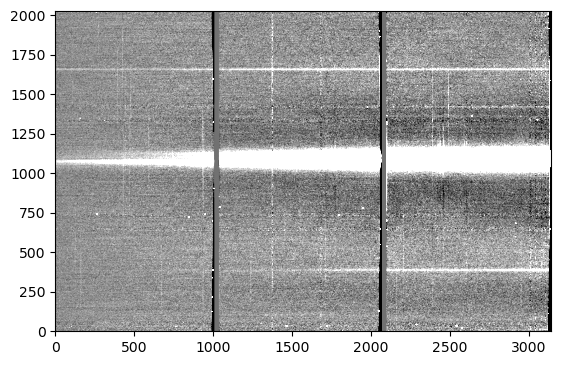

In [26]:
# plotting the 2D spectrum

plt.close('all')
fig, ax = plt.subplots()
ax.imshow(ad[0].data, origin="lower", cmap='grey', vmin=np.percentile(ad[0].data, 10), vmax=np.percentile(ad[0].data, 80))
plt.show()

In [27]:
from gempy.adlibrary import plotting

Filename: N20181114S0419_1D.fits
Tags: EXTRACTED GEMINI GMOS LS NORTH OVERSCAN_SUBTRACTED OVERSCAN_TRIMMED
    PREPARED PROCESSED PROCESSED_SCIENCE SIDEREAL SPECT

Pixels Extensions
Index  Content                  Type              Dimensions     Format
[ 0]   science                  NDAstroData       (3140,)        float64
          .variance             ADVarianceUncerta (3140,)        float64
          .mask                 ndarray           (3140,)        uint16

Other Extensions
               Type        Dimensions
.PROVENANCE    Table       (11, 4)
.PROVHISTORY   Table       (24, 4)


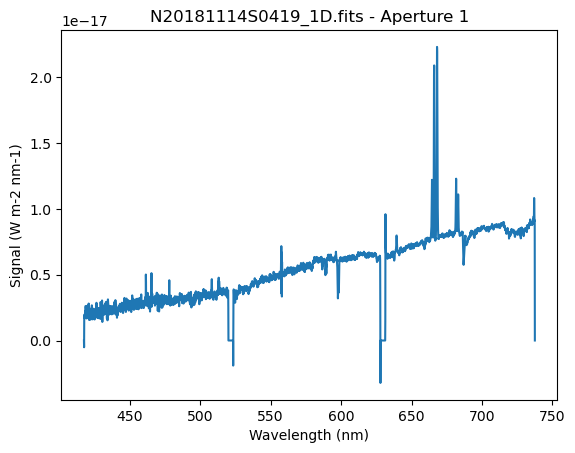

In [28]:
ad = astrodata.open("N20181114S0419_1D.fits")
ad.info()

plt.ioff()
plotting.dgsplot_matplotlib(ad, 1)
plt.ion()
